# Import libraries

In [1]:
import os
import glob
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Functions

In [2]:
def plot_style():
    plt.grid()
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='k')

    plt.rcParams['xtick.direction'] = 'in' 
    plt.rcParams['ytick.direction'] = 'in' 
    plt.rcParams['xtick.top'] = True 
    plt.rcParams['ytick.right'] = True  

    params = {'legend.fontsize': '20',
         'figure.figsize': (10,6),
         'axes.labelsize': '26',
         'axes.titlesize':'26',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'xtick.major.pad':'16',
         'ytick.major.pad':'16'}
    
    pylab.rcParams.update(params)

# Prepare folders

In [3]:
if os.path.exists('results') == False:
    os.mkdir('results')

In [4]:
if os.path.exists('tmp') == False:
    os.mkdir('tmp')

# Open data

In [5]:
cwd = os.path.dirname(os.getcwd())

In [6]:
source_dir = os.path.join('data','*')

# Read DATA

In [7]:
df_list=[]
df_list_err=[]
df_list_coe=[]

In [8]:
for f in glob.glob(os.path.join(source_dir, '*.csv')):
    art = f.split(os.path.sep)[-2]
    filename=f.split(os.path.sep)[-1]
    df_tmp=pd.read_csv(f, 
                       names=['x','y'],
                       converters = { 'x' : lambda s : float(s.replace(',', '.')), 'y' : lambda s : float(s.replace(',', '.')), },
                       delimiter=';')

    if filename.startswith('err'):              
        energy=float(filename[3:-7].replace(',', '.'))
        
        df_tmp_err = pd.DataFrame()
        df_tmp_err['x_err']=df_tmp.x[0::2]
        df_tmp_err['sf_err_up'] = df_tmp.y[0::2].values
        df_tmp_err['sf_err_down']= df_tmp.y[1::2].values
        df_tmp_err['energy']=int(energy*1000)
        df_tmp_err['article']=art
        df_tmp_err['nr']=np.arange(df_tmp_err.energy.size)
        df_list_err.append(df_tmp_err)
            
    elif filename.startswith("coe"):        
        energy=float(filename[3:-7].replace(',', '.'))
        
        df_tmp_coe = pd.DataFrame()
        df_tmp_coe["alpha"]=df_tmp.x.iloc[[0]]
        df_tmp_coe["beta"]=df_tmp.x[1]
        df_tmp_coe["alpha_err"]=df_tmp.x[2]
        df_tmp_coe["beta_err"]=df_tmp.x[3]
        df_tmp_coe["LET"]=df_tmp.x[4]
        #print(df_tmp_coe)
        df_tmp_coe['article']=art
        df_tmp_coe['energy']=int(energy*1000)
        df_list_coe.append(df_tmp_coe)

    else:        
        energy=float(filename[0:-7].replace(',', '.'))
        df_tmp['energy']=int(energy*1000)
        df_tmp['article']=art        
        df_tmp['nr']=np.arange(df_tmp.energy.size)
       
        df_list.append(df_tmp)

In [9]:
result_err=pd.concat(df_list_err, axis=0)
result_err.replace(',', '.', inplace=True)
result_err['article'] = result_err.article.astype('category')

result_coe=pd.concat(df_list_coe, axis=0)
result_coe.replace(',', '.', inplace=True)
result_coe['article'] = result_coe.article.astype('category')

result=pd.concat(df_list, axis=0)
result.replace(',', '.', inplace=True)
result.rename(index=str, columns={"x": "dose", "y": "sf"}, inplace=True)
result['article'] = result.article.astype('category')

In [10]:
df_list_cells=[]

for f in glob.glob(os.path.join(source_dir, '*.xls')):    
    df = pd.read_excel(io=f, usecols=(0,2), names=('article', 'cells'))
    df_list_cells.append(df)
    
result_cells=pd.concat(df_list_cells, axis=0)

result_cells['article'] = result_cells.article.astype('str')
result_cells['cells'] = result_cells.cells.astype('category')

result_cells.reset_index(drop=True,inplace=True)

In [11]:
result_err['sf_error']=0.5*abs(result_err.sf_err_up-result_err.sf_err_down)
result_err["weight"]=1/(result_err.sf_error)

In [12]:
result.reset_index(drop=True,inplace=True)
result1 = pd.merge(result_cells, result, on=['article'])
result1['article'] = result1.article.astype('category')

# Concatenation of DataFrames

In [13]:
result.reset_index(drop=True,inplace=True)
result_coe.reset_index(drop=True,inplace=True)
result_err.reset_index(drop=True,inplace=True)

In [14]:
result_data = pd.merge(result_coe, result1,on=["article","energy"])
result_data['article'] = result_data.article.astype('category')

In [15]:
#result_data.dose.clip_lower(0,inplace=True)

In [16]:
result_data.set_index(['article','energy','nr'],inplace=True)
result_err.set_index(['article','energy','nr'],inplace=True)

In [17]:
result_all = pd.merge(result_data,  result_err,left_index = True, right_index=True)

In [18]:
df2 = result_all.groupby(["article",'energy']).max()
df2.is_copy=False

In [19]:
for name, group in df2.groupby('article'):
        for energy, data in group.groupby('energy'):
            df2.loc[(name,energy),'alpha_ref'] = group.loc[name].loc[0].alpha
            df2.loc[(name,energy),'alpha_ref_err'] = group.loc[name].loc[0].alpha_err
            df2.loc[(name,energy),'beta_ref'] = group.loc[name].loc[0].beta
            df2.loc[(name,energy),'beta_ref_err'] = group.loc[name].loc[0].beta_err

In [20]:
for name, group in df2.groupby('article'):
        for energy, data in group.groupby('energy'):
            df2.loc[(name, energy),'alpha_alpharef_err'] = data['alpha_err'].values/data['alpha_ref'].values -data['alpha'].values*data['alpha_ref_err'].values/(data['alpha_ref'].values*data['alpha_ref'].values)
            df2.loc[(name, energy),'beta_betaref_err'] = data['beta_err'].values/data['beta_ref'].values -data['beta'].values*data['beta_ref_err'].values/(data['beta_ref'].values*data['beta_ref'].values)

<ipython-input-20-b66376a33127>:4: RuntimeWarning: invalid value encountered in true_divide
  df2.loc[(name, energy),'beta_betaref_err'] = data['beta_err'].values/data['beta_ref'].values -data['beta'].values*data['beta_ref_err'].values/(data['beta_ref'].values*data['beta_ref'].values)


# Analyze Hypothesis using Oryginal Data

In [21]:
bb0,bb1,err,err0 =[],[],[],[]

for name, group in df2.groupby('article'):
    #print(name)
        for energy, data in group.groupby('energy'):

            bb0.append(data.beta_ref.values)
            bb1.append(data.beta.values)
            err.append(data.beta_err.values)
            err0.append(data.beta_ref_err.values)
err = np.concatenate(err, axis=0 )
err0 = np.concatenate(err0, axis=0 )

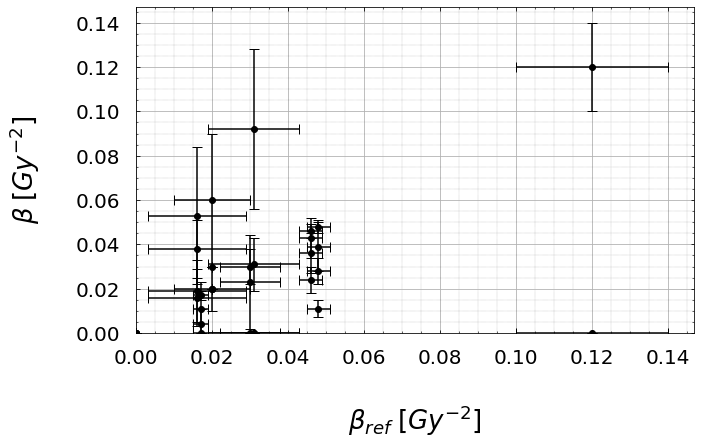

In [26]:
plt.errorbar(bb0,bb1,
             yerr=err,
             xerr=err0,
             zorder=2, 
             fmt='o',color='k',capsize=5)
plot_style()

plt.ylabel(r'$\beta\;[Gy^{-2}]$'+'\n')
plt.xlabel('\n'+r'$\beta_{ref} \;[Gy^{-2}]$')
  
plt.xlim(0,None)
plt.ylim(0,None)

tmp=pd.DataFrame(list(zip(bb0,bb1,err,err0)),
              columns=['beta_ref','beta', 'bera_ref_err','beta_err'])
tmp.to_csv("results/figure_4_2")

plt.savefig(fname="results/figure_4_2",dpi= 700)

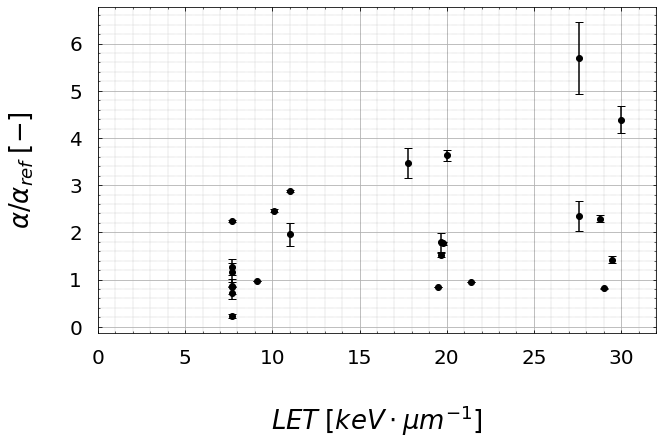

In [23]:
plt.errorbar(df2.LET.values[df2.LET.values>0],
             df2.alpha[df2.LET.values>0].values/df2.alpha_ref[df2.LET.values>0].values,
             yerr=df2['alpha_alpharef_err'][df2.LET.values>0],
             capsize=4,
             fmt='o',color='k', label='both limits (default)')

plot_style()

plt.xlabel('\n'+r'$LET \; [keV \cdot\mu m^{-1}]$')
plt.ylabel(r'$\alpha/ \alpha_{ref}\;[-]$'+'\n')

plt.xlim(0,32)

tmp=pd.DataFrame(list(zip(df2.LET.values[df2.LET.values>0],
                          df2.alpha[df2.LET.values>0].values/df2.alpha_ref[df2.LET.values>0].values,
                          df2['alpha_alpharef_err'][df2.LET.values>0])),
              columns=['LET','alpha/alpha_ref', 'alpha_err'])
tmp.to_csv("results/figure_4_1")

plt.savefig(fname="results/figure_4_1",dpi= 700)

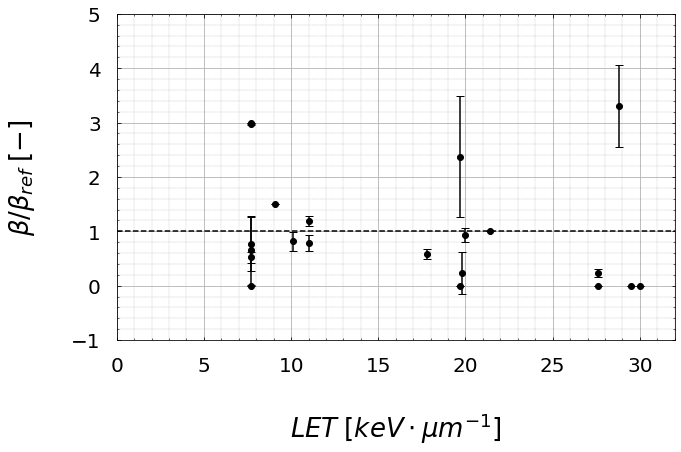

In [24]:
plt.errorbar(df2.LET[(df2.LET.values>0) & (df2.beta_ref>0)].values,
             df2.beta[(df2.LET.values>0) & (df2.beta_ref>0)].values/df2.beta_ref[(df2.LET.values>0.) & (df2.beta_ref>0)].values,
             yerr=df2['beta_betaref_err'][(df2.LET.values>0) & (df2.beta_ref>0)],
             capsize=4,
             fmt='o',color='k')
plot_style()

plt.xlabel('\n'+r'$LET \; [keV \cdot\mu m^{-1}]$')
plt.ylabel(r'$\beta / \beta_{ref}\;[-]$'+'\n')
plt.axhline(1,c='k',ls='--')

plt.xlim(0,32)
plt.ylim(-1,5)

tmp=pd.DataFrame(list(zip(df2.LET[(df2.LET.values>0) & (df2.beta_ref>0)].values,
                           df2.beta[(df2.LET.values>0) & (df2.beta_ref>0)].values/df2.beta_ref[(df2.LET.values>0.) & (df2.beta_ref>0)].values,
                           df2['beta_betaref_err'][(df2.LET.values>0) & (df2.beta_ref>0)])),
              columns=['LET','beta/beta_ref', 'beta_err'])
tmp.to_csv("results/figure_4_3")

plt.savefig(fname="results/figure_4_3",dpi= 700)

# Save temporary files

In [25]:
fname = os.path.join('tmp','rawdata.h5')
result_all.to_hdf(fname, 'data', format='table')